# Lending Club Loan Default Project

## The Data

LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California.[3] It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform.

### Our Goal

Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can we build a model thatcan predict wether or nor a borrower will pay back their loan? This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. Keep in mind classification metrics when evaluating the performance of your model!

The "loan_status" column contains our label.

# Import Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,f1_score, accuracy_score, recall_score, roc_auc_score, roc_curve

# might be needed depending on your version of Jupyter
%matplotlib inline

## Loading the data

**First, Let's import the data info file which contains information about the attributes in the dataset**

In [0]:
data_info = pd.read_csv('lending_club_info.csv',index_col='LoanStatNew')

In [404]:
print(data_info.loc['revol_util']['Description'])

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


In [0]:
def feat_info(col_name):
    print(data_info.loc[col_name]['Description'])

In [406]:
feat_info('mort_acc')

Number of mortgage accounts.


In [0]:
df = pd.read_csv('lending_club_loan_two.csv')

In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

# Section 1: Exploratory Data Analysis

**OVERALL GOAL: Get an understanding for which variables are important, view summary statistics, and visualize the data**

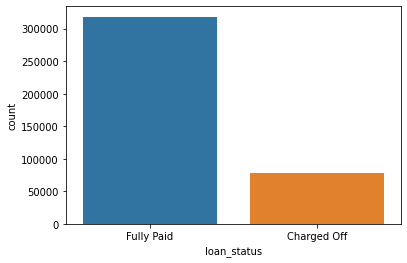

In [409]:
sns.countplot('loan_status',data = df)

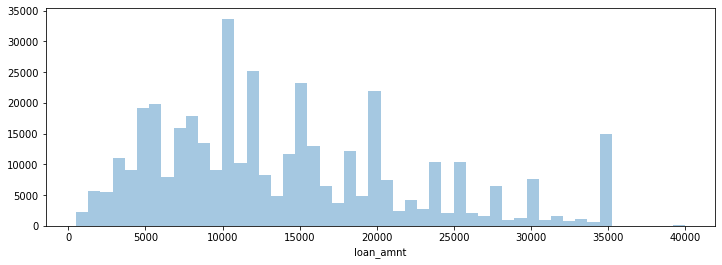

In [410]:
plt.figure(figsize=(12,4))
sns.distplot(df['loan_amnt'],kde = False)

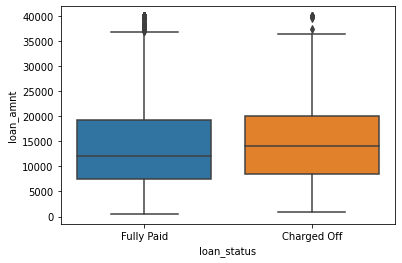

In [411]:
sns.boxplot(x='loan_status',y='loan_amnt',data=df)

**Let's calculate the summary statistics for the loan amount, grouped by the loan_status**

In [412]:
df[['loan_status','loan_amnt']].groupby(by='loan_status').describe()

loan_amnt                             ...                           
                count          mean          std  ...      50%      75%      max
loan_status                                       ...                           
Charged Off   77673.0  15126.300967  8505.090557  ...  14000.0  20000.0  40000.0
Fully Paid   318357.0  13866.878771  8302.319699  ...  12000.0  19225.0  40000.0

[2 rows x 8 columns]

**Let's explore the Grade and SubGrade columns that LendingClub attributes to the loans.**

In [413]:
print(df['grade'].unique())
print(df['sub_grade'].unique())

['B' 'A' 'C' 'E' 'D' 'F' 'G']
['B4' 'B5' 'B3' 'A2' 'C5' 'C3' 'A1' 'B2' 'C1' 'A5' 'E4' 'A4' 'A3' 'D1'
 'C2' 'B1' 'D3' 'D5' 'D2' 'E1' 'E2' 'E5' 'F4' 'E3' 'D4' 'G1' 'F5' 'G2'
 'C4' 'F1' 'F3' 'G5' 'G4' 'F2' 'G3']


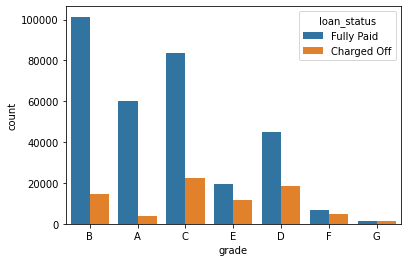

In [414]:
sns.countplot(x='grade',hue='loan_status',data=df)

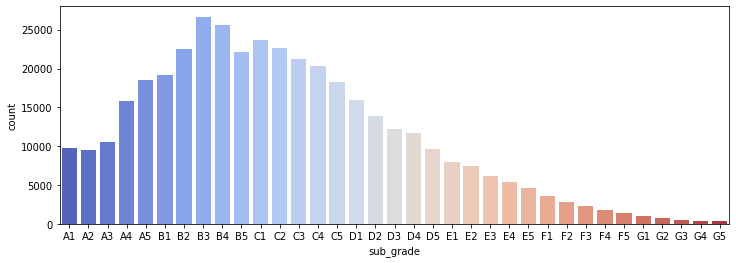

In [415]:
plt.figure(figsize=(12,4))
sns.countplot(x='sub_grade',data=df,order=df['sub_grade'].value_counts().index.sort_values(),palette='coolwarm')

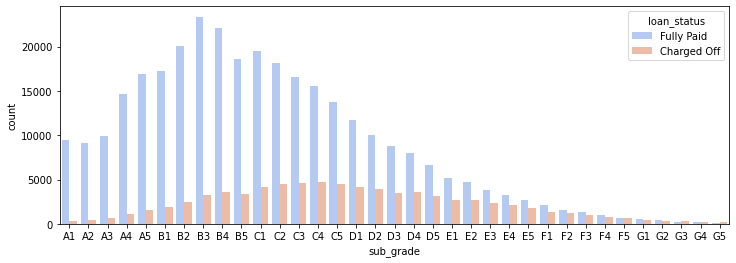

In [416]:
plt.figure(figsize=(12,4))
sns.countplot(x='sub_grade',data=df,order=df['sub_grade'].value_counts().index.sort_values(),hue='loan_status',palette='coolwarm')

**Since F and G grades don't get paid back often, let's explore them in depth**

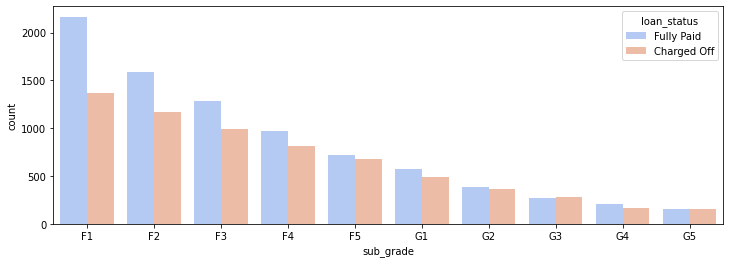

In [417]:
df['sub_grade'].value_counts().index.sort_values()[25:]
df_vis = pd.DataFrame(df[['sub_grade','loan_status']][df['sub_grade'].isin(df['sub_grade'].value_counts().index.sort_values()[25:])])
plt.figure(figsize=(12,4))
sns.countplot(x='sub_grade',data=df_vis,order=df_vis['sub_grade'].value_counts().index.sort_values(),hue='loan_status',palette='coolwarm')

**Let's convert the target variable into dummies**

In [418]:
df['loan_repaid'] = pd.get_dummies(df['loan_status'],drop_first=True)
df[['loan_repaid','loan_status']]

,loan_repaid,loan_status
0,1,Fully Paid
1,1,Fully Paid
2,1,Fully Paid
3,1,Fully Paid
4,0,Charged Off
...,...,...
396025,1,Fully Paid
396026,1,Fully Paid
396027,1,Fully Paid
396028,1,Fully Paid


## Let's explore correlation

In [419]:
df.corr()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,loan_repaid
loan_amnt,1.000000,0.168921,0.953929,0.336887,0.016636,0.198556,-0.077779,0.328320,0.099911,0.223886,0.222315,-0.106539,-0.059836
int_rate,0.168921,1.000000,0.162758,-0.056771,0.079038,0.011649,0.060986,-0.011280,0.293659,-0.036404,-0.082583,0.057450,-0.247758
installment,0.953929,0.162758,1.000000,0.330381,0.015786,0.188973,-0.067892,0.316455,0.123915,0.202430,0.193694,-0.098628,-0.041082
annual_inc,0.336887,-0.056771,0.330381,1.000000,-0.081685,0.136150,-0.013720,0.299773,0.027871,0.193023,0.236320,-0.050162,0.053432
dti,0.016636,0.079038,0.015786,-0.081685,1.000000,0.136181,-0.017639,0.063571,0.088375,0.102128,-0.025439,-0.014558,-0.062413
open_acc,0.198556,0.011649,0.188973,0.136150,0.136181,1.000000,-0.018392,0.221192,-0.131420,0.680728,0.109205,-0.027732,-0.028012
pub_rec,-0.077779,0.060986,-0.067892,-0.013720,-0.017639,-0.018392,1.000000,-0.101664,-0.075910,0.019723,0.011552,0.699408,-0.019933
revol_bal,0.328320,-0.011280,0.316455,0.299773,0.063571,0.221192,-0.101664,1.000000,0.226346,0.191616,0.194925,-0.124532,0.010892
revol_util,0.099911,0.293659,0.123915,0.027871,0.088375,-0.131420,-0.075910,0.226346,1.000000,-0.104273,0.007514,-0.086751,-0.082373
total_acc,0.223886,-0.036404,0.202430,0.193023,0.102128,0.680728,0.019723,0.191616,-0.104273,1.000000,0.381072,0.042035,0.017893


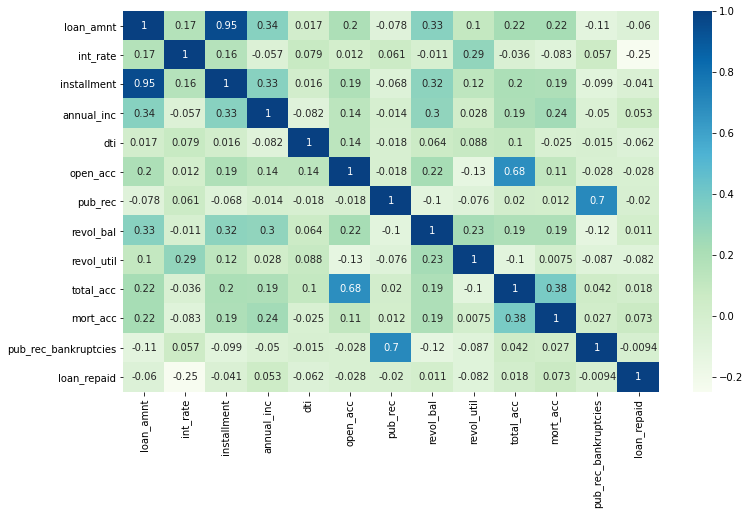

In [420]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),cmap = 'GnBu',annot=True)

**Installment and loan amount seem to be highly correlated. Let's visualize these variables**

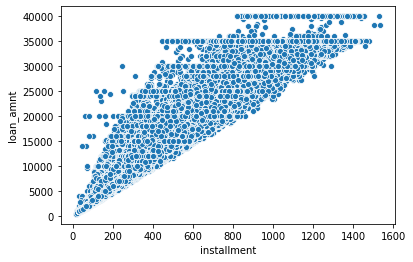

In [421]:
sns.scatterplot(x='installment',y='loan_amnt',data=df)

**Let's visualize the correlation between the new target variable and the numeric attributes**

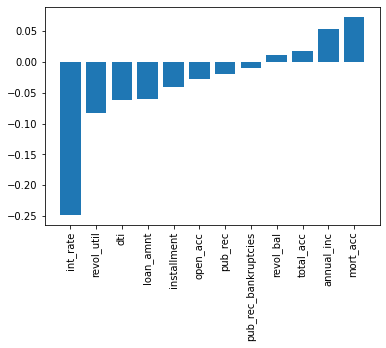

In [422]:
plt.bar(df.corr()['loan_repaid'][:-1].sort_values().index,df.corr()['loan_repaid'][:-1].sort_values())
plt.xticks(rotation=90)
plt.show()

# Section 2: Data PreProcessing

**Section Goals: Remove or fill any missing data. Remove unnecessary or repetitive features. Convert categorical string features to dummy variables.**

## Missing Data

**Let's explore this missing data columns. We use a variety of factors to decide whether or not they would be useful, to see if we should keep, discard, or fill in the missing data.**

In [423]:
df.isna().sum()/len(df) * 100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64

**Let's examine emp_title and emp_length to see whether it will be okay to drop them.**

In [424]:
print(feat_info('emp_title'))
print(feat_info('emp_length'))

The job title supplied by the Borrower when applying for the loan.*
None
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
None


In [425]:
df['emp_title'].nunique()

173105

In [426]:
df['emp_title'].value_counts()

Teacher                             4389
Manager                             4250
Registered Nurse                    1856
RN                                  1846
Supervisor                          1830
                                    ... 
Windel Marx Lane & Mittendorf          1
Project Manager-Tubular Services       1
Care Center Ministries                 1
Quality Asurance Consultant            1
Marketing Project Coordinator          1
Name: emp_title, Length: 173105, dtype: int64

**Realistically there are too many unique job titles to try to convert this to a dummy variable feature. Let's remove that emp_title column.**

In [0]:
df.drop('emp_title',axis=1,inplace=True)

In [428]:
sorted(df['emp_length'].dropna().unique())

['1 year',
 '10+ years',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 '< 1 year']

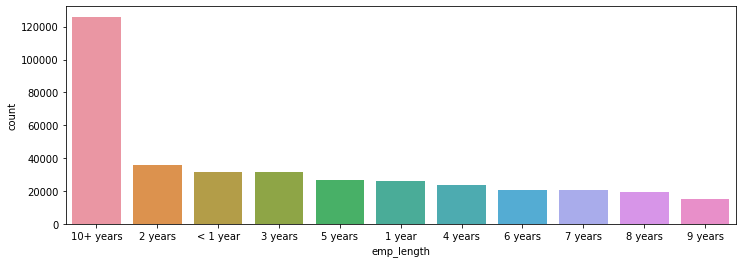

In [429]:
plt.figure(figsize=(12,4))
sns.countplot(x='emp_length',data=df,order=df['emp_length'].value_counts().sort_values(ascending = False).index)

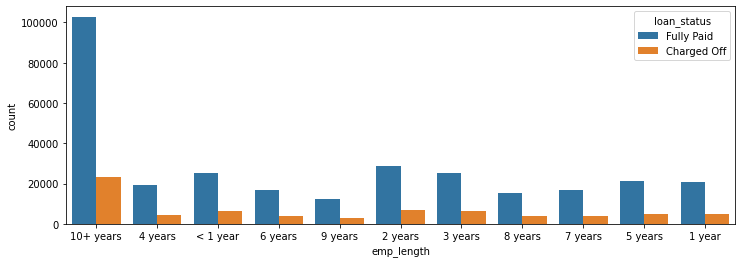

In [430]:
plt.figure(figsize=(12,4))
sns.countplot(x='emp_length',data=df,hue='loan_status')

**This still doesn't really inform us if there is a strong relationship between employment length and being charged off, what we want is the percentage of charge offs per category. Essentially informing us what percent of people per employment category didn't pay back their loan.**

In [0]:
df_sub = df[['loan_status','emp_length']][df['loan_status'] == df['loan_status'].unique()[1]]
df_denom = df[['loan_status','emp_length']].groupby('emp_length').count()

In [432]:
df_final = df_sub.groupby('emp_length').count().divide(df_denom)
df_final

,loan_status
emp_length,
1 year,0.199135
10+ years,0.184186
2 years,0.193262
3 years,0.195231
4 years,0.192385
5 years,0.192187
6 years,0.189194
7 years,0.194774
8 years,0.199760


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

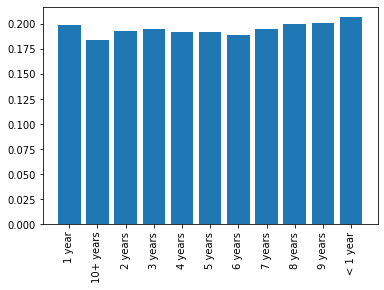

In [433]:
plt.bar(x=df_final.index,height=df_final.values.flatten())
plt.xticks(rotation=90)

**Charge off rates are extremely similar across all employment lengths. We can drop the emp_length column.**

In [0]:
df.drop('emp_length',axis=1,inplace=True)

**Let's review the title column and the purpose column to determine of this is repeated information**

In [435]:
df['title'].unique()

array(['Vacation', 'Debt consolidation', 'Credit card refinancing', ...,
       'Credit buster ', 'Loanforpayoff', 'Toxic Debt Payoff'],
      dtype=object)

In [436]:
df['purpose'].unique()

array(['vacation', 'debt_consolidation', 'credit_card',
       'home_improvement', 'small_business', 'major_purchase', 'other',
       'medical', 'wedding', 'car', 'moving', 'house', 'educational',
       'renewable_energy'], dtype=object)

**The title column is simply a string subcategory/description of the purpose column. We will drop the title column**

In [0]:
df.drop('title',axis=1,inplace=True)

**Let's explore the mort_acc feature**

In [438]:
feat_info('mort_acc')

Number of mortgage accounts.


In [439]:
df['mort_acc'].value_counts()

0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
23.0         2
32.0         2
26.0         2
31.0         2
30.0         1
28.0         1
34.0         1
Name: mort_acc, dtype: int64

In [440]:
df.corr()['mort_acc'].sort_values()

int_rate               -0.082583
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
installment             0.193694
revol_bal               0.194925
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
mort_acc                1.000000
Name: mort_acc, dtype: float64

**Since mort_acc and total_acc are correlated, we will try to impute based on the total_acc**

In [441]:
df_group = df.groupby('total_acc').mean()['mort_acc']
df_group

total_acc
2.0      0.000000
3.0      0.052023
4.0      0.066743
5.0      0.103289
6.0      0.151293
           ...   
124.0    1.000000
129.0    1.000000
135.0    3.000000
150.0    2.000000
151.0    0.000000
Name: mort_acc, Length: 118, dtype: float64

In [0]:
def calc(x):
  if np.isnan(x['mort_acc']):
    return df_group[x['total_acc']]
  else:
    return x['mort_acc']

df['mort_acc'] = df.apply(calc, axis=1)

**Let's drop the remaining rows with missing values**

In [0]:
df.dropna(inplace=True)

## One Hot Encoding

**First, let's list all the categorical variables**

In [444]:
df.select_dtypes('object').columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

**We will map the value 36 months to 36 and 60 months to 60 in the term attribute**

In [445]:
df['term'].value_counts()

 36 months    301247
 60 months     93972
Name: term, dtype: int64

In [0]:
df['term'] = df['term'].map({df['term'].value_counts().index[0]:36,df['term'].value_counts().index[1]:60})

**The information presented by the grade feature is aready contained within the subgrade feature. Therefore, this feature can be dropped**

In [0]:
df.drop('grade',axis=1,inplace=True)

**Let's create dummies for sub_grade,verification_status,application_type,initial_list_status and purpose**

In [0]:
df = df.drop('sub_grade',axis = 1).join(pd.get_dummies(df['sub_grade'],drop_first=False))

In [0]:
df = df.drop('verification_status',axis = 1).join(pd.get_dummies(df['verification_status'],drop_first=False))

In [0]:
df = df.drop('application_type',axis = 1).join(pd.get_dummies(df['application_type'],drop_first=False))

In [0]:
df = df.drop('initial_list_status',axis = 1).join(pd.get_dummies(df['initial_list_status'],drop_first=True))

In [0]:
df = df.drop('purpose',axis = 1).join(pd.get_dummies(df['purpose'],drop_first=False))

**For home_ownership we will replace NONE and ANY with OTHER, so that we end up with just 4 categories, MORTGAGE, RENT, OWN, OTHER.**

In [453]:
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

In [0]:
df['home_ownership'] = np.where((df['home_ownership'] == 'ANY') | (df['home_ownership'] == 'NONE'),'OTHER',df['home_ownership'])

In [0]:
df = df.drop('home_ownership',axis = 1).join(pd.get_dummies(df['home_ownership'],drop_first=False))

**Let's feature engineer a zip code column from the address in the data set.**

In [456]:
df['address'].value_counts()

USS Johnson\nFPO AE 48052                                  8
USCGC Smith\nFPO AE 70466                                  8
USS Smith\nFPO AP 70466                                    8
USNS Johnson\nFPO AE 05113                                 8
USNS Johnson\nFPO AP 48052                                 7
                                                          ..
26496 Fernandez Trail Apt. 297\nNew Aprilfurt, CT 48052    1
84431 Adams Mountains\nSouth Davidport, AZ 48052           1
94644 Barnes Burgs Apt. 078\nJonathanton, IL 93700         1
173 Williams Run Apt. 192\nDouglasland, MT 48052           1
3201 Espinoza Street\nPort Barbaraborough, CA 30723        1
Name: address, Length: 392898, dtype: int64

In [0]:
df['zip_code'] = df['address'].apply(lambda x: x[-5:])

In [0]:
df = df.drop(['address','zip_code'],axis = 1).join(pd.get_dummies(df['zip_code'],drop_first=False))

**Since we wouldn't know beforehand whether or not a loan would be issued when using our model, we wouldn't have an issue_date. We will drop this feature.**

In [0]:
df.drop('issue_d',axis=1,inplace=True)

**Let's extract the year from the earliest_cr_line feature**

In [460]:
df['earliest_cr_line'].value_counts()

Oct-2000    3013
Aug-2000    2930
Oct-2001    2890
Aug-2001    2879
Nov-2000    2729
            ... 
Mar-1960       1
Aug-1962       1
Jan-1957       1
Apr-1960       1
Jun-1959       1
Name: earliest_cr_line, Length: 684, dtype: int64

In [0]:
df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda x: x[-4:])

In [0]:
df['earliest_cr_year'] = df['earliest_cr_year'].astype('int64')

In [0]:
df.drop('earliest_cr_line',axis=1,inplace=True)

# Hold Out Method

In [0]:
df.drop('loan_status',axis=1,inplace=True)

In [0]:
X = df.drop('loan_repaid',axis=1).values
y = df['loan_repaid'].values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Scaling

In [0]:
minmax = MinMaxScaler()

In [468]:
minmax.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
X_train = minmax.transform(X_train)

In [0]:
X_test = minmax.transform(X_test)

# Data Modeling

In [0]:
model = Sequential()

model.add(Dense(78,'relu'))
model.add(Dense(39,'relu'))
model.add(Dense(19,'relu'))
model.add(Dense(1,'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd')

In [0]:
early_stop = EarlyStopping(monitor='val_loss',mode="min",patience=20)

In [473]:
model.fit(x=X_train,y = y_train,epochs=1000,validation_data=(X_test,y_test),
          callbacks = [early_stop],batch_size = 256)

Epoch 1/1000
1236/1236 [==============================] - 3s 3ms/step - loss: 0.4738 - val_loss: 0.4123
Epoch 2/1000
1236/1236 [==============================] - 3s 2ms/step - loss: 0.3377 - val_loss: 0.2910
Epoch 3/1000
1236/1236 [==============================] - 3s 2ms/step - loss: 0.2752 - val_loss: 0.2716
Epoch 4/1000
1236/1236 [==============================] - 3s 2ms/step - loss: 0.2662 - val_loss: 0.2696
Epoch 5/1000
1236/1236 [==============================] - 3s 2ms/step - loss: 0.2638 - val_loss: 0.2700
Epoch 6/1000
1236/1236 [==============================] - 3s 2ms/step - loss: 0.2626 - val_loss: 0.2646
Epoch 7/1000
1236/1236 [==============================] - 3s 2ms/step - loss: 0.2620 - val_loss: 0.2712
Epoch 8/1000
1236/1236 [==============================] - 3s 3ms/step - loss: 0.2615 - val_loss: 0.2640
Epoch 9/1000
1236/1236 [==============================] - 3s 2ms/step - loss: 0.2611 - val_loss: 0.2633
Epoch 10/1000
1236/1236 [==============================] - 3s 2m

**Model Loss**


**The below figure shows the number of epochs at which the loss values flatten out, we have selected a patience value of 20, which means that the model will continue to execute for 20 epochs after the curve flattens to ensure that there is no subsequent change in loss value**



In [0]:
model_loss = pd.DataFrame(model.history.history)

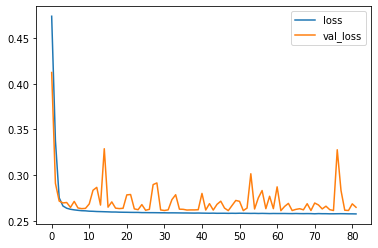

In [475]:
model_loss.plot()

In [0]:
pred = np.stack(model.predict_classes(X_test),axis =1)[0]

In [477]:
print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("F1 Score: ",f1_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       1.00      0.43      0.60     15658
           1       0.88      1.00      0.93     63386

    accuracy                           0.89     79044
   macro avg       0.94      0.72      0.77     79044
weighted avg       0.90      0.89      0.87     79044

Accuracy Score:  0.886873133950711
Recall Score:  0.9995898147855994
F1 Score:  0.9340861847827691


Predicted,0,1,All
True,,,
0,6742,8916,15658
1,26,63360,63386
All,6768,72276,79044
